In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import norm
from sklearn.tree import DecisionTreeClassifier, plot_tree

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Input, AveragePooling1D, Dropout, Softmax
from keras.optimizers import Adam, Nadam
from keras.regularizers import L2
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, Callback, LambdaCallback
from keras.metrics import Metric

from time import perf_counter
import functools
import itertools
import sys

In [2]:
stresses = ['Gm', 'Drought', 'Nutrient_Deficiency', 'Fs', 'Salinity']

In [3]:
csv_path = r'..\combined.csv'
df = pd.read_csv(csv_path)
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df.drop(columns=['Fungal_infection'], inplace=True, errors='ignore')
df[stresses] = df[stresses].astype(bool)

C:\Users\amitt\AppData\Local\Temp\ipykernel_4232\1297277926.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [4]:
spec_cols = [col for col in df.columns if col[0] == 'X']

In [4]:
df

,Experiment,Time,Species,Soil,Gm,Drought,Nutrient_Deficiency,Fs,Salinity,X350,...,B_carotene,Glucose,Fructose,Sucrose,Sugars,Starch,Ellagic,Gal,Rut,CTs
0,2018_EEL,0,Black Walnut,F,False,False,False,False,False,0.0995,...,180.672913,4.114120,4.321044,2.106877,10.377295,2.430284,215.327766,123.012942,37.911137,16.153354
1,2018_EEL,0,Black Walnut,F,False,False,False,False,False,0.0995,...,185.691351,5.253359,4.398900,2.090093,10.430779,1.620732,159.648059,140.224392,34.913800,12.904982
2,2018_EEL,0,Black Walnut,F,False,False,False,False,False,0.0995,...,223.876583,5.130809,4.122389,2.148208,9.001072,1.204313,169.093819,137.268720,26.315744,13.429072
3,2018_EEL,0,Black Walnut,F,False,False,False,False,False,0.0995,...,134.435161,6.996149,5.455238,1.557863,14.307212,5.177277,98.561955,70.040873,15.097144,13.590456
4,2018_EEL,0,Black Walnut,F,False,False,False,False,False,0.0995,...,160.339162,6.490596,3.602786,2.163037,10.592087,1.899691,244.166164,169.102470,40.167820,18.469889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23651,2019_Martell,2,Red Oak,NaN,False,False,False,False,True,0.1006,...,50.680347,0.491981,2.142298,2.022112,6.362280,0.064974,229.208398,46.702728,30.452206,2.524192
23652,2019_Martell,2,Red Oak,NaN,False,False,False,False,True,0.1006,...,2.102093,3.317779,2.946461,4.029103,8.485325,0.677890,228.950841,102.741536,46.396327,6.360440
23653,2019_Martell,2,Red Oak,NaN,False,False,False,False,True,0.1006,...,7.064565,1.433723,1.722290,1.883972,5.001576,-2.390555,439.018157,102.577759,34.947248,9.521822
23654,2019_Martell,2,Red Oak,NaN,False,False,False,False,True,0.1006,...,11.266166,0.839294,2.183542,2.365718,5.722241,0.596050,311.728885,39.374667,34.287740,1.880939


In [5]:
trait_cols = df.columns[list(df.columns).index(spec_cols[-1])+1:]

In [6]:
trait_cols

Index(['Photo', 'Ci', 'Cond', 'CTleaf', 'Trmmol', 'WUEi', 'WUEin', 'Fv_Fm',
       'Fv_Fo', 'PI', 'SLA', 'LWC', 'Suc', 'OP', 'OP100', 'RWC', 'WP', 'N',
       'C', 'Neoxanthin', 'Violaxanthin', 'Lutein', 'Zeaxanthin', 'Chl_b',
       'Chl_a', 'B_carotene', 'Glucose', 'Fructose', 'Sucrose', 'Sugars',
       'Starch', 'Ellagic', 'Gal', 'Rut', 'CTs'],
      dtype='object')

## NN

In [7]:
x = df[trait_cols].values

x = (x - x.min(axis=0))/(x.max(axis=0)-x.min(axis=0))
y = df[stresses].values

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2)

In [30]:
del df

In [8]:
class Accuracy(Metric):
    def __init__(self, name='accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.accuracy = self.add_variable(
            shape=(),
            initializer='zeros',
            name='accuracy'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = tf.cast(tf.reduce_all((y_pred > .5) == y_true, axis=1), tf.float32)
        
        self.accuracy.assign(tf.reduce_mean(p))

    def result(self):
        return self.accuracy

In [9]:
model = Sequential([
    Input((x.shape[1],)),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.2),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.2),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.2),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.1),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.1),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.1),
    Dense(y.shape[1], activation='sigmoid'),
])

model.compile(optimizer=Nadam(1e-4), loss='binary_crossentropy', metrics=[Accuracy])

In [10]:
start = perf_counter()

history = model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_data=(x_val, y_val),
    batch_size=80,
)

print(perf_counter() - start)

Epoch 1/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3752 - loss: 0.4967 - val_accuracy: 0.2500 - val_loss: 0.3325
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3963 - loss: 0.3308 - val_accuracy: 0.5000 - val_loss: 0.2760
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4147 - loss: 0.2896 - val_accuracy: 0.3333 - val_loss: 0.2568
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4398 - loss: 0.2668 - val_accuracy: 0.6667 - val_loss: 0.2408
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4484 - loss: 0.2529 - val_accuracy: 0.5833 - val_loss: 0.2324
Epoch 6/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4634 - loss: 0.2414 - val_accuracy: 0.5833 - val_loss: 0.2158
Epoch 7/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4729 - loss: 0.2327 - val_accuracy: 0.3333 - val_loss: 0.2109
Epoch 8/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4975 - loss: 0.2242 - val_accu

In [11]:
y_pred = model.predict(x_val)

(~y_val).mean(), ((y_pred > .5) == y_val).mean()

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(0.8365173288250212, 0.9991546914623838)

Text(0.5, 1.0, 'NN Loss over Training')

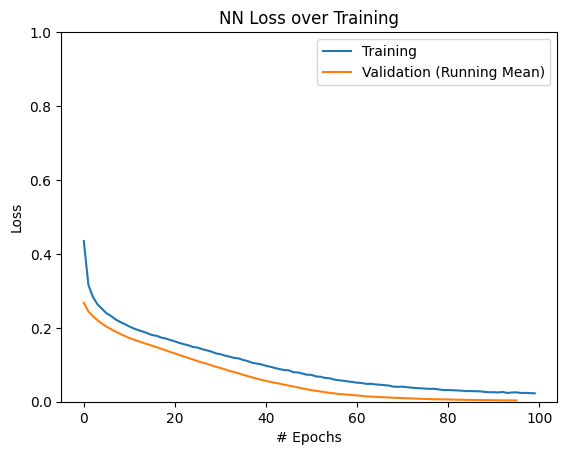

In [12]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['loss'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_loss']), np.ones(5)/5, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Loss')
ax.set_ylim((0, 1))
ax.set_title('NN Loss over Training')

## Interpretation

### Layer-Wise Relevance Propagation

In [13]:
n_samples = x.shape[0]

In [14]:
# i_s = np.random.choice(x_pca.shape[0], n_samples, replace=False)
# temp_x = x_pca[i_s]

temp_x = np.copy(x)
activations = [temp_x]
for layer in model.layers:
    temp_x = layer(temp_x)
    activations.append(temp_x.numpy())

In [15]:
try:
    x = x.numpy()
except:
    pass

In [16]:
alpha = 1
beta = 0
epsilon = 1e-5

prev_relevance = activations[-1]

for i in range(len(activations)-1,0,-1):
    start_time = perf_counter()
    
    weights = np.ones((activations[i-1].shape[1], activations[i].shape[1]))
    
    if model.layers[i-1].weights:
        weights = model.layers[i-1].weights[0].numpy()

    weights_p = weights * (weights > 0)
    weights_n = weights * (weights < 0)

    pre_activations_p = activations[i-1] @ weights_p
    pre_activations_n = activations[i-1] @ weights_n

    r = np.zeros(activations[i-1].shape)

    for j in range(activations[i-1].shape[1]):        
        r_a = activations[i-1][:,j,np.newaxis] * np.repeat(weights_p[j,np.newaxis],activations[i-1].shape[0],axis=0) / (pre_activations_p + epsilon)

        if beta == 0:
            r[:,j] = ((alpha * r_a) * prev_relevance).sum(axis=1)
            continue

        r_b = activations[i-1][:,j,np.newaxis] * np.repeat(weights_n[j,np.newaxis],activations[i-1].shape[0],axis=0) / (pre_activations_n + epsilon)
        r[:,j] = ((alpha * r_a - beta * r_b) * prev_relevance).sum(axis=1)

    prev_relevance = r

    print(f'{i}: {perf_counter() - start_time}s')

13: 0.41361330007202923s
12: 22.071010400075465s
11: 13.461758400080726s
10: 21.623760499991477s
9: 13.484450600109994s
8: 21.82645169994794s
7: 13.492802300024778s
6: 21.708442199975252s
5: 13.456138200126588s
4: 21.791195099940524s
3: 13.45753480005078s
2: 21.75417700014077s
1: 2.7542139000725s


In [17]:
del activations

In [18]:
# input_relevances = prev_relevance / prev_relevance.max()
input_relevances = prev_relevance

#### Graphing

In [19]:
# n_stressed_samples = 6
# assert n_stressed_samples < n_samples

# i_stressed = np.random.choice(np.arange(i_s.shape[0])[y[i_s].any(axis=1)], n_stressed_samples, replace=False)
# i_s_stressed = i_s[i_stressed]

In [20]:
# fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize=(12,9))
# axs = list(itertools.chain.from_iterable(axs))
# x_h = np.arange(input_relevances.shape[1])

# ax_min, ax_max = input_relevances[i_stressed].min() * 1.05,input_relevances[i_stressed].max() * 1.05

# for i, ax in enumerate(axs):
#     ax.bar(x_h, input_relevances[i_stressed[i]])
#     ax.set_xticks(x_h, labels=trait_cols, rotation=90)
#     ax.set_title(
#         f'Sample #{i_s_stressed[i]} {[stresses[j] for j in range(len(stresses)) if y[i_s_stressed[i]][j]]}'
#     )
#     ax.set_ylabel('Normalized Relevance')
#     ax.set_ylim((ax_min, ax_max))

# fig.suptitle(f'Layer-wise Relevance Propagation ($\\alpha$={alpha}, $\\beta$={beta})')

#### Save to File

In [21]:
# lrp_df = pd.DataFrame(input_relevances, index=i_s, columns=trait_cols)
# lrp_df[stresses] = df.loc[i_s, stresses]
# lrp_df.to_csv(f'lrp_a{alpha}_b{beta}.csv')

## Trait Classification

### SIS
Simplified version of [this paper](https://proceedings.mlr.press/v89/carter19a/carter19a.pdf). 

Iteratively replaces different traits with their mean values. The trait that, when replaced, yields the highest accuracy is the least important. The least important trait is then replaced with its mean, and the process is repeated for the remaining traits, until the accuracy is below 80%. The remaining traits are thus the ones necessary for at least an 80% accuracy.  

In [22]:
important = {}

for stress_i, stress in enumerate(stresses):
    target = np.zeros((len(stresses),))
    target[stress_i] = 1
    
    selected = (y == target).all(axis=1)
    checked = np.zeros((x.shape[1],)).astype(bool)

    mask = np.repeat((1-np.identity(x.shape[1])).reshape((x.shape[1], 1, x.shape[1])), selected.sum(), axis=1)
    means = x.mean(axis=0).reshape((1, 1, x.shape[1])).repeat(x.shape[1], axis=0).repeat(selected.sum(), axis=1)
    
    remove_traits = []
    temp_x = np.copy(x[selected])
    
    for i in range(x.shape[1]):  
        masked = np.repeat(temp_x.reshape((1, selected.sum(), x.shape[1])), x.shape[1], axis=0)
        
        masked = (masked * mask) + (means * (1-mask))
        
        acc = np.zeros((x.shape[1],))
        
        for j in range(x.shape[1]):
            if checked[j]:
                continue
            acc[j] = ((model(masked[j]) > .5).numpy() == target).all(axis=1).mean()
        
        least_important = acc.argmax()
    
        temp_x = masked[least_important]
    
        remove_traits.append((least_important, acc[least_important]))
        checked[least_important] = True

    remove_traits = np.array(remove_traits)
    important[stress] = list(trait_cols[remove_traits[:,1]<.8])

    print(f'{stress}: {important[stress]}')

Gm: ['Sugars', 'Starch', 'Ellagic', 'Gal', 'Rut', 'CTs']
Drought: ['WP', 'N', 'C', 'Neoxanthin', 'Violaxanthin', 'Lutein', 'Zeaxanthin', 'Chl_b', 'Chl_a', 'B_carotene', 'Glucose', 'Fructose', 'Sucrose', 'Sugars', 'Starch', 'Ellagic', 'Gal', 'Rut', 'CTs']
Nutrient_Deficiency: ['Gal']
Fs: ['LWC', 'Chl_a', 'Sucrose', 'Sugars', 'Starch', 'Ellagic', 'Gal', 'Rut', 'CTs']
Salinity: ['Violaxanthin', 'Lutein', 'Zeaxanthin', 'Chl_b', 'Chl_a', 'B_carotene', 'Glucose', 'Fructose', 'Sucrose', 'Sugars', 'Starch', 'Ellagic', 'Gal', 'Rut', 'CTs']


#### Noise

In [23]:
# noise_important = {}

# for stress_i, stress in enumerate(stresses):
#     target = np.zeros((len(stresses),))
#     target[stress_i] = 1
    
#     selected = (y == target).all(axis=1)
#     checked = np.zeros((x.shape[1],)).astype(bool)

#     mask = np.repeat((1-np.identity(x.shape[1])).reshape((x.shape[1], 1, x.shape[1])), selected.sum(), axis=1)
#     # noise = x.mean(axis=0).reshape((1, 1, x.shape[1])).repeat(x.shape[1], axis=0).repeat(selected.sum(), axis=1)
#     sigma = 2
#     noise = ((x[selected]) + sigma*x.std(axis=0)*(np.random.random_sample((selected.sum(), x.shape[1])) - 1/sigma)).reshape((1, selected.sum(), x.shape[1])).repeat(x.shape[1], axis=0)
    
#     remove_traits = []
#     temp_x = np.copy(x[selected])
    
#     for i in range(x.shape[1]):  
#         masked = np.repeat(temp_x.reshape((1, selected.sum(), x.shape[1])), x.shape[1], axis=0)
        
#         masked = (masked * mask) + (noise * (1-mask))
        
#         acc = np.zeros((x.shape[1],))
        
#         for j in range(x.shape[1]):
#             if checked[j]:
#                 continue
#             acc[j] = ((model(masked[j]) > .5).numpy() == target).all(axis=1).mean()
        
#         least_important = acc.argmax()
    
#         temp_x = masked[least_important]
    
#         remove_traits.append((least_important, acc[least_important]))
#         checked[least_important] = True

#     remove_traits = np.array(remove_traits)
#     noise_important[stress] = list(trait_cols[remove_traits[:,1]<.8])

#     print(f'{stress}: {noise_important[stress]}')

### Max

In [40]:
ir_normal = input_relevances / input_relevances.max()

In [41]:
means = np.empty((len(stresses), trait_cols.shape[0]))
for stress_i in range(len(stresses)):
    mask = np.zeros((y.shape[1],))
    mask[stress_i] = 1
    
    means[stress_i] = ir_normal[(y==mask).all(axis=1)].mean(axis=0)

In [80]:
thresh = .17

for stress_i in range(len(stresses)):
    i = (-1*means[stress_i, means[stress_i] > thresh]).argsort()
    print(f'{stresses[stress_i]}: {list(trait_cols[means[stress_i] > thresh][i])}')

print(f'Using threshold: {thresh}')

Gm: ['Glucose']
Drought: ['N', 'Gal', 'Fv_Fo', 'PI']
Nutrient_Deficiency: ['Fv_Fo']
Fs: ['N', 'Gal', 'PI']
Salinity: ['Fv_Fo', 'WUEin', 'Zeaxanthin']
Using threshold: 0.17


Sorted

### Dominance

In [26]:
dists = np.empty((len(stresses), len(stresses)))

for s1 in range(len(stresses)):
    mask1 = np.zeros((len(stresses),))
    mask1[s1] = 1

    mean1 = x[(y==mask1).all(axis=1)].mean(axis=0)
    
    for s2 in range(len(stresses)):
        mask2 = np.zeros((len(stresses),))
        mask2[s2] = 1

        mean2 = x[(y==mask2).all(axis=1)].mean(axis=0)

        mask_both = np.logical_or(mask1, mask2)
        mean_both = x[(y==mask_both).all(axis=1)].mean(axis=0)

        d1 = np.linalg.norm(mean_both - mean1)
        d2 = np.linalg.norm(mean_both - mean2)

        if d1 + d2 == 0:
            dists[s1,s2] = 0
        else:
            dists[s1,s2] = (d2 - d1)/(d1 + d2)

        print(f'{stresses[s1]}: {(y==mask1).all(axis=1).sum()}, {stresses[s2]}: {(y==mask2).all(axis=1).sum()}, both: {(y==mask_both).all(axis=1).sum()}')

Gm: 3038, Gm: 3038, both: 3038
Gm: 3038, Drought: 406, both: 225
Gm: 3038, Nutrient_Deficiency: 2774, both: 0
Gm: 3038, Fs: 1826, both: 1714
Gm: 3038, Salinity: 2013, both: 0
Drought: 406, Gm: 3038, both: 225
Drought: 406, Drought: 406, both: 406
Drought: 406, Nutrient_Deficiency: 2774, both: 200
Drought: 406, Fs: 1826, both: 225
Drought: 406, Salinity: 2013, both: 0
Nutrient_Deficiency: 2774, Gm: 3038, both: 0
Nutrient_Deficiency: 2774, Drought: 406, both: 200
Nutrient_Deficiency: 2774, Nutrient_Deficiency: 2774, both: 2774
Nutrient_Deficiency: 2774, Fs: 1826, both: 0
Nutrient_Deficiency: 2774, Salinity: 2013, both: 1937
Fs: 1826, Gm: 3038, both: 1714
Fs: 1826, Drought: 406, both: 225
Fs: 1826, Nutrient_Deficiency: 2774, both: 0
Fs: 1826, Fs: 1826, both: 1826
Fs: 1826, Salinity: 2013, both: 0
Salinity: 2013, Gm: 3038, both: 0
Salinity: 2013, Drought: 406, both: 0
Salinity: 2013, Nutrient_Deficiency: 2774, both: 1937
Salinity: 2013, Fs: 1826, both: 0
Salinity: 2013, Salinity: 2013, bot

C:\Users\amitt\AppData\Local\Temp\ipykernel_20700\1216449937.py:16: RuntimeWarning: Mean of empty slice.
  mean_both = x[(y==mask_both).all(axis=1)].mean(axis=0)
C:\Users\amitt\.virtualenvs\stress_detection-fEHOVlkj\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


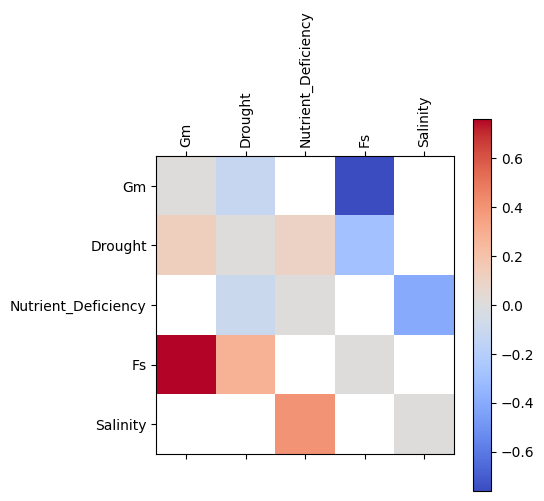

In [27]:
plt.matshow(dists, cmap='coolwarm')
plt.xticks(np.arange(len(stresses)), stresses, rotation=90)
plt.yticks(np.arange(len(stresses)), stresses)
plt.colorbar()

Positive value means closer to the variable on the vertical axis, or vertical axis variable is dominant over the horizontal axis variable.

### Point-Biserial Correlation

In [28]:
corrs = np.empty((len(stresses), len(trait_cols)))

for s_i in range(len(stresses)):
    mask = np.zeros((len(stresses),))
    mask[s_i] = 1
    mask_v = (y==mask).all(axis=1)

    mask_n = np.zeros((len(stresses),))
    mask_n_v = (y==mask_n).all(axis=1)

    c = (x[mask_v].mean(axis=0) - x[mask_n_v].mean(axis=0)) / x[mask_v | mask_n_v].std(axis=0)
    corrs[s_i] = c * np.sqrt(mask_v.sum() * mask_n_v.sum()) / (mask_v | mask_n_v).sum() 

In [86]:
norm.cdf(np.abs(corrs)).max()

0.6830284271884219